In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 
import random
import copy

In [2]:
class Sudoku:
    rows = []
    cols = []
    grids = []
    initial_matrix=[]
    def __init__(self, gridSize, initial_matrix, rows = None):
        self.gridSize = gridSize
        self.initial_matrix=initial_matrix
        if rows is None:
            
            self.rows = np.array([np.random.permutation(np.arange(1, (gridSize**2)+1)) for _ in range((gridSize**2))])
            self.rows = np.where(initial_matrix > 0, initial_matrix, self.rows)
        else:
            self.rows=rows
        
        self._unrepeat()
        self._updateLists()
        self.fitness = self._getFitness()
        
    def _getFitness(self):
        score = 0
        for row in self.rows:
            if(len(np.unique(row)) == self.gridSize**2):
                score += 1

        for col in self.cols:
            if(len(np.unique(col)) == self.gridSize**2):
                score += 1

        for grid in self.grids:
            if(len(np.unique(grid)) == self.gridSize**2):
                score += 1

        return score

    def _unrepeat(self):
        boolean_matrix=np.zeros_like(self.initial_matrix)
        
        for i in range(0,self.gridSize**2):
            for j in range(0,self.gridSize**2):
                if self.initial_matrix[i,j]>0:
                    boolean_matrix[i,self.initial_matrix[i,j]-1]=1
        
        for i in range(0,self.gridSize**2):
            for j in range(0,self.gridSize**2):
                if boolean_matrix[i,self.rows[i,j]-1]==1 and self.initial_matrix[i,j]==0:
                    for f in range(0,self.gridSize**2):
                        if boolean_matrix[i,f]==0:
                            self.rows[i,j]=f+1
                            boolean_matrix[i,f]=1
                            break
                else:
                    boolean_matrix[i,self.rows[i,j]-1]=1
                    
                    
    def _updateLists(self):
        self.cols = np.transpose(self.rows)
        
        self.grids = [[] for _ in range(9)]
        #self.grids=np.zeros_like(self.initial_matrix)
        
        for row_id in range(self.gridSize**2):
            for col_id in range(self.gridSize**2):
                idx = int(col_id // self.gridSize + ((row_id // self.gridSize) * self.gridSize))
                self.grids[idx].append(self.rows[row_id,col_id])

        self.grids = np.array(self.grids, dtype=np.ndarray)
        self._getFitness()
    def uniformCrossover(self,B,reproductionProbability):
        
        aux=np.zeros_like(self.initial_matrix)
        if random.random() < reproductionProbability:
            return Sudoku(3,self.initial_matrix)
        else:
            for i in range(0,self.gridSize**2):
                for j in range(0,self.gridSize**2):
                    if self.initial_matrix[i,j]>0:
                        aux[i,j]=self.initial_matrix[i,j]
                    else:
                        if random.random() < 0.5:
                             aux[i,j]=self.rows[i,j]
                        else:
                            aux[i,j]=B.rows[i,j]
            return Sudoku(3,self.initial_matrix,aux)
                        

    def pointCrossover(self, B, reproductionProbability):
        if random.random() < reproductionProbability:
            crosspoint = random.randint(0, (self.gridSize**2)-1)
            return Sudoku(self.gridSize, np.concatenate((self.rows[:crosspoint], B.rows[crosspoint:])))
        else:
            return Sudoku(3, self.initial_matrix,self.rows)
            
    def mutation(self, mutationProbability):
        if random.random() < mutationProbability:
            idx = random.randint(0, (self.gridSize**2)-1)
            self.rows[idx] =  np.random.permutation(np.arange(1, (self.gridSize**2)+1))
            self.rows = np.where(self.initial_matrix > 0, self.initial_matrix, self.rows)
            self._updateLists()

    def plot(self):
        
        fig = plt.figure(figsize=(5,5))
        plt.title("Score: " + str(self.fitness))
        ax = fig.add_subplot()
        ax.set_xlim((0, 9))
        ax.set_ylim((0, 9))

        #ax.annotate("Rectangle", (cx, cy), color='black', weight='bold', fontsize=10, ha='center', va='center')
        ax.add_patch(plt.Rectangle((0, 0), 3,3))
        ax.add_patch(plt.Rectangle((0, 6), 3,3))
        ax.add_patch(plt.Rectangle((3, 3), 3,3))
        ax.add_patch(plt.Rectangle((6, 0),3,3))
        ax.add_patch(plt.Rectangle((6, 6), 3,3))
        for i in range(self.gridSize**2):
            for j in range(self.gridSize**2):
                
                ax.annotate(str(self.rows[8-j,i]), (i+0.5, j+0.5), color='black', weight='bold', fontsize=15, ha='center', va='center')
        '''count = 0
        for queen in solution:
            ax.add_patch(plt.Rectangle((count, queen), 1, 1))
            count += 1'''
        plt.grid(True)
        plt.show(fig)

In [3]:
class GeneticAlgorithm:

    def __init__(self, gridSize, populationSize, generations, reproductionProbability, mutationProbability,initial_matrix):
        self.initial_matrix=initial_matrix
        self.gridSize = gridSize
        self.populationSize = populationSize
        self.generations = generations
        self.reproductionProbability = reproductionProbability
        self.mutationProbability = mutationProbability

    def _getPopulation(self):
        return [Sudoku(self.gridSize,self.initial_matrix) for _ in range(self.populationSize)]

    def _getElite(self, A, B):
        return A if A.fitness > B.fitness else B

    def _tournamentSelection(self, population, k=2):
        community = random.sample(population, k)
        localElite = community[0]
    
        for chromosome in community:
            localElite = self._getElite(chromosome, localElite)
                
        return localElite

    def solve(self):

        fatherPopulation = self._getPopulation() # First Gen
        sonPopulation = []

        eliteIndividual = fatherPopulation[0]
        actualGeneration = 0

        while actualGeneration < self.generations: # OR we haven't found a good solution
            
            for _ in range(self.populationSize):
                G11 = self._tournamentSelection(fatherPopulation)
                G12 = self._tournamentSelection(fatherPopulation)

                G21 = G11.uniformCrossover(G12, self.reproductionProbability)
                G21.mutation(self.mutationProbability)

                sonPopulation.append(G21)
                
                eliteIndividual = self._getElite(G21, eliteIndividual)
            
            if eliteIndividual.fitness>=27:
                break
            fatherPopulation = sonPopulation
            sonPopulation = []

            actualGeneration += 1
        
        return eliteIndividual

In [4]:
sdk=np.matrix([[2,5,7,4,0,0,0,6,9],
               [6,0,1,2,0,0,7,0,0],
               [0,0,8,9,0,0,0,0,5],
               [4,0,0,8,0,7,0,2,1],
               [0,0,0,6,3,4,9,7,8],
               [7,0,9,5,0,2,4,0,6],
               [0,0,0,0,0,0,0,5,2],
               [0,0,0,0,0,0,1,9,7],
               [9,0,0,7,0,5,0,0,0]
    ])

In [5]:
#Test
G11 = Sudoku(3,sdk)
G12 = Sudoku(3,sdk)
print(G11.rows)
print("----------------")
print(G12.rows)

[[2 5 7 4 1 3 8 6 9]
 [6 3 1 2 5 4 7 8 9]
 [2 1 8 9 3 4 6 7 5]
 [4 6 3 8 9 7 5 2 1]
 [1 5 2 6 3 4 9 7 8]
 [7 1 9 5 3 2 4 8 6]
 [1 3 6 8 4 7 9 5 2]
 [3 2 4 5 6 8 1 9 7]
 [9 1 2 7 3 5 4 8 6]]
----------------
[[2 5 7 4 8 1 3 6 9]
 [6 3 1 2 4 5 7 9 8]
 [1 2 8 9 3 4 6 7 5]
 [4 9 3 8 5 7 6 2 1]
 [1 2 5 6 3 4 9 7 8]
 [7 1 9 5 3 2 4 8 6]
 [1 7 3 6 4 9 8 5 2]
 [2 3 5 6 4 8 1 9 7]
 [9 1 4 7 2 5 3 8 6]]


In [6]:
model = GeneticAlgorithm(3, 100, 50, 0.4, 0.2,sdk)
solution = model.solve()

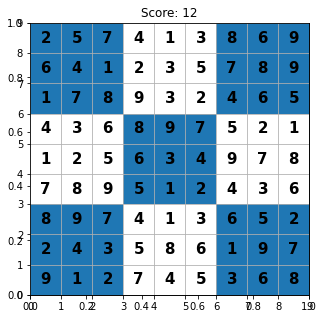

In [7]:
solution.plot()

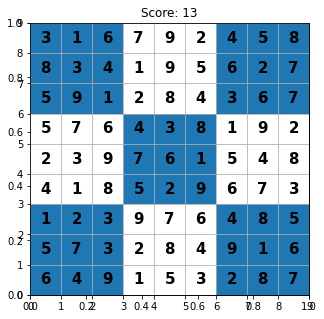

In [8]:
sdk2=np.matrix([[0,0,6,0,9,0,0,5,0],
               [8,3,4,0,0,5,0,0,0],
               [5,9,1,2,8,0,0,6,0],
               [0,0,0,4,3,0,0,0,2],
               [0,0,9,7,0,1,5,4,8],
               [0,0,8,5,0,0,6,7,0],
               [1,0,0,9,7,0,4,0,5],
               [0,0,3,0,0,0,0,1,6],
               [6,4,0,0,5,0,2,8,0]
    ])
model = GeneticAlgorithm(3, 100, 100, 0.4, 0.2,sdk2)
solution2 = model.solve()
solution2.plot()